# 신경망 학습
앞에서 신경망이 입력 데이터로부터 예측을 수행하는 과정을 간략히 살펴보았다. 하지만, 신경망이 학습하는 과정을 생략했었다.   
Labeled Classification에서 신경망이 학습하여 도달할 목표는, weight 파라미터를 조정하며 예측값과 정답과의 오차를 점차 줄여나가 결국
최상의 예측을 내놓는 파라미터를 찾는 것이다.  그래서,
- 오차를 구해야 하고
- 오차를 줄여나가는 알고리즘이 필요하며,
- 결과를 평가할 방법이 필요하다.

## 1. 오차Error
- MSE(Mean Squared Error)
    - 편차의 제곱들의 합으로 오차를 측정한다. 
    - sample의 크기에 따라 달라지므로 스케일링(normalize)을 하여 비교한다. 미분편의를 위해 $1/2$을 곱했다.
$$
MSE = \frac{1}{2} \sum\limits_{k}(y_k - t_k)^2
$$

- Cross Entropy Error
    - Softmax로 예측하는 경우에 쓰이는 오차함수이다. 식을 보면 알 수 있듯이, 지수확률로 나타나는 예측값에 로그오차가 쓰이는 것은 자연스럽다.
    - CEE는 거리로 구하는 다른 오차함수와는 달리, 분포끼리의 정보차로 오차를 표현한다. 다시말하면,
    - 예측값에 최적인(최소인) 정보description체계로써($-\log{y_k}$) 레이블 분포($t_k$)를 기술하는 경우, 그것의 기대값($\sum{t_k}...$) 이다.
    > (참고로 로그값은 밑수에 대한 지수를 나타내므로 '밑수' 진법의 자리수, 즉 (이진법의 경우의) 비트수가 된다.  
    > 확률 $y_k$로 분포하는 경우의 수를 최소한의 비트수로 구분한다면, $-\log{y_k}$가 되는 것이다.)
    - 예측분포가 정답분포와 얼마나 맞아 떨어지는지 그 타당성을 설명하는 Bernoulli 분포의 **log-likelihood 로그 우도**와 관계가 밀접하다.
    - $y_k$확률로 맞으면 1 틀리면 0 (성공/실패)인 one-hot으로 나타낸 정답에 대한 Bernoulli 분포(성공/실패 분포) $t_k$의 pmf는 다음과 같다.
$$
p(t_k)= y_{k}^{t_k}, \quad t_k \in \{0, 1\},\quad \sum_k t_k = 1
$$  
    - 이 때, 기대값은,
$$
\mu = E(t) = 0\cdot y_{(fail)}^0 + \cdots + 1 \cdot y_{(success)}^1 =1\cdots 1 \cdot y_{(success)}^1 \cdots 1 =  \prod\limits_{k} y_{k}^{t_k}
$$
    - 으로서, k의 모든 경우(MNIST에서는 10가지)에 대한 likelihood와 같은 값이다. 즉,
$$
L = \prod_k y_{k}^{t_k} = \mu
$$ 
    - 이 때, log-likelihood는, 
$$
\log{L} = \sum\limits_{k} t_k \log{y_k}
$$
    - 설명력이 클 수록, 즉 오류가 작을 수록 음수인 위의 값은 커져 0에 가까워진다.
    - 오류의 정도를 기술하기 위해 이 결과를 양수(절대값)로 바꾸어주면, CEE는 다음과 같이 쓸 수 있다. 
$$
CEE \equiv -\log{L} = - \sum\limits_{k}t_k \log{y_k}, \quad t_k \text{ : label, } y_k \text{ : predicted }
$$
    - 정답(실제)분포를 도출된 분포($y_k$)로 잘 설명이 안 될 수록, 즉 타당성이 작을 수록 likelihood는 작아지고, 오류는 커지게 된다.

- 기타 RMSE(Root Mean Squared Error, $\ell_2$ norm), MAE(Mean Absolute Error), ... 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set()

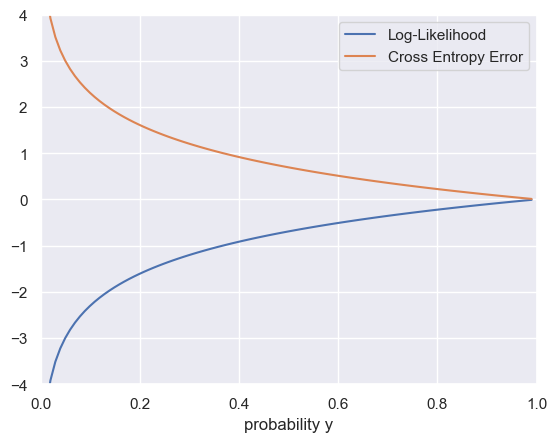

In [2]:
# t가 one-hot인 경우에 채택된 확률 y 에 따른, logL, CEE를 구해본다.
# logL = 1*log(y) + 0 + ... = log(y), 
# CEE = -logL
y = np.linspace(0.01, 0.99, 100)
logL = np.log(y)
plt.plot(y, logL, label='Log-Likelihood')
plt.plot(y, -logL, label='Cross Entropy Error')
plt.xlabel('probability y')
plt.xlim(0, 1)
plt.ylim(-4, 4)
plt.legend(loc='best')
plt.show()

In [3]:
# MSE
def mean_squared_error(y, t):
    return 0.5 * np.sum((y -t)**2)

y = np.random.randint(0, 10, 5)
t = np.random.randint(0, 10, 5)
y, t, mean_squared_error(y, t)

(array([6, 7, 3, 4, 3]), array([7, 8, 3, 3, 0]), 6.0)

In [4]:
# CEE
def cross_entropy_error(y, t):
    """CEE:
    Cross Entropy Error for a batch y and one-hot label t.

    parameters
    ----------
    y, t: probability array
          If y -> 0, log(y) -> -oo. Hence, delta was introduced.
    batch_size: number of data of a batch

    returns
    -------
    float
    """
    if y.ndim == 1:
       y = y.reshape(1, y.size)
       t = t.reshape(1, t.size) 
       
    delta = 1e-7
    batch_size = y.shape[0]
    return - np.sum(t*np.log(y + delta)) / batch_size


In [5]:
# batch_size = 5
y = np.random.dirichlet(np.ones(10),5)
y.ndim, y.shape, y.sum(axis=1), y.argmax(axis=1)

(2, (5, 10), array([1., 1., 1., 1., 1.]), array([4, 4, 5, 2, 1], dtype=int64))

In [6]:
# MNIST one-hot-encoding
labels = np.random.randint(0, 10, 5)
t = np.zeros((5, 10))
for i, v in enumerate(labels):
    t[i][v] = 1

labels, t, t.argmax(axis=1)

(array([6, 3, 0, 7, 8]),
 array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]]),
 array([6, 3, 0, 7, 8], dtype=int64))

In [7]:
cross_entropy_error(y, t) 

2.839166795629585

In [8]:
cross_entropy_error(y, t)

2.839166795629585

In [9]:
t[np.arange(5), labels] # advanced indexing

array([1., 1., 1., 1., 1.])

In [10]:
accuracy_cnt = (y.argmax(axis=1) == labels).sum()
accuracy_cnt

0

In [11]:
# CEE for both one-hot encoding and valued labels
def cross_entropy_error(y, t):
    """CEE:
    Cross Entropy Error for a batch y and one-hot label t.
    The idea is that one-hot encoding has only 1 at the true element and 0 elsewhere,
    so that t * log(y) == 0. Hence, the only valid element is the 1 and to 
    obtain the result, one only has to simply calculate on that element.

    parameters
    ----------
    y, t: probability array
          If y -> 0, log(y) -> -oo. Hence, delta was introduced.
    batch_size: number of data of a batch

    returns
    -------
    float
    """
    if y.ndim == 1:
       y = y.reshape(1, y.size)
       t = t.reshape(1, t.size) 

    if y.size == t.size: # if one-hot
        t = t.argmax(axis=1) # recover label values 

    delta = 1e-7
    batch_size = y.shape[0]
    return - np.sum(np.log(y[np.arange(batch_size), t] + delta)) / batch_size

## 2. Gradient
오차를 줄이기 위한 방법으로 Gradient Descent 가 있다. 경사가 큰 방향으로 파라미터를 옮기다 보면 최적값을 찾을 수 있다는 점에 착안한다.  
- 경사gradient Array는 다음과 같다.
$$
\text{ Gradient : }  
\frac{\partial L}{\partial \mathbf{W}} = \begin{bmatrix}
\frac{\partial L}{\partial w_{11}} & \cdots & \frac{\partial L}{\partial w_{1\ell}} \\
\vdots & \ddots & \vdots\\
\frac{\partial L}{\partial w_{n1}} & \cdots & \frac{\partial L}{\partial w_{n\ell}}

\end{bmatrix}, \quad L\text{ : loss function }, \mathbf{W} \text{ : weigthts}$$
- 한 편, 일반적인 scalar valued function $f$의 gradient는 입력값 $x$의 각 element $x_i$ 에 대한 편미분값의 배열이 되므로 입력값인 $x$와 동일한 shape이 된다.
- numerical하게 편미분을 구할 때에는 forward difference 와 backward difference를 평균한 값으로 구한다. 즉,
$$
\frac{\partial f}{\partial x_i} = \frac{\frac{f(x_i + h) - f(x_i)}{h} + \frac{f(x_i) - f(x_i - h)}{h}}{2} = \frac{f(x_i + h) - f(x_i - h)}{2h}
$$
- 일반적인 scalar valued 함수에 대한 gradient는 다음과 같은 코드가 될 것이다.

In [12]:
def num_gradient_without_batch(f, x):
    """Gradient of a scalar valued function in a numerical way.
    x.size iteration required!
    At position x known in numerical values, for each i, we calculate
    f(xi + h) and f(xi - h), Hence, at least, 2 * x.size computations
    are needed.

    Parameters
    ----------
    f : scalar valued function of an array
    x : input array of any shape.

    Return
    ------
    gradient: An array of the shape of x
    """
    h = 1e-4     # small displacement
    grad = np.zeros_like(x)
    # iterate (the size of x) times
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        original = x[idx]
        # xi -> xi + h : forward
        x[idx] = float(original) + h
        fxh1 = f(x) # f(xi + 1)
        # xi -> xi - h : backward
        x[idx] = float(original) - h
        fxh2 = f(x) # f(xi - 1)
        # average difference: central difference
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = original # retrieve the original value

        it.iternext()

    return grad

    
def num_gradient(f, X):
    """Gradient of a scalar valued function in a numerical way.
    Since X may be a batch data or not, reshaping X and iteration by batch_size
    are required.

    Parameters
    ----------
    f : scalar valued function of an array
    X : input array of any shape with "first dimension of batch_size".

    Return
    ------
    gradient: An array of the shape of X
    """

    if X.ndim == 1:
        # X = X.reshape(1, X.size)
        return num_gradient_without_batch(f, X)    
    grad = np.zeros_like(X)

    for i, x in enumerate(X):    # for each record x in a batch X
        grad[i] = num_gradient_without_batch(f, x)

    return grad

(324,)


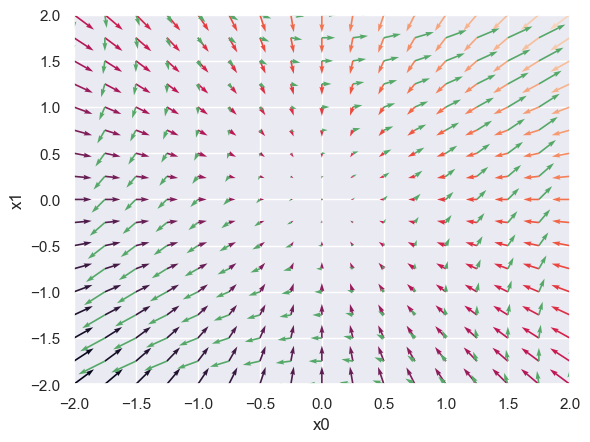

In [13]:
def function_2(x):
    return np.sum(x[0]**2 + 2*x[0]*x[1])
  
def square_sum(x):
    if x.ndim == 1:
        x = x.reshape(1, x.size)
    return np.sum(x**2, axis=1)

x0 = np.arange(-2, 2.5, 0.25)
x1 = np.arange(-2, 2.5, 0.25)
X, Y = np.meshgrid(x0, x1)
    
X = X.flatten()
Y = Y.flatten()
    
pts = np.vstack((X, Y)).T               # keep the shape (X.size, 2)
grad = num_gradient(square_sum, pts).T  # dx, dy : shape(2, X.shape)
grad2 = num_gradient(function_2, pts).T
color_array = grad[0] + grad[1]  
print(color_array.shape)  
plt.quiver(X, Y, -grad[0], -grad[1], color_array, angles="xy")
plt.quiver(X, Y, grad2[0], grad2[1], color='g')
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.xlabel('x0')
plt.ylabel('x1')
plt.show()

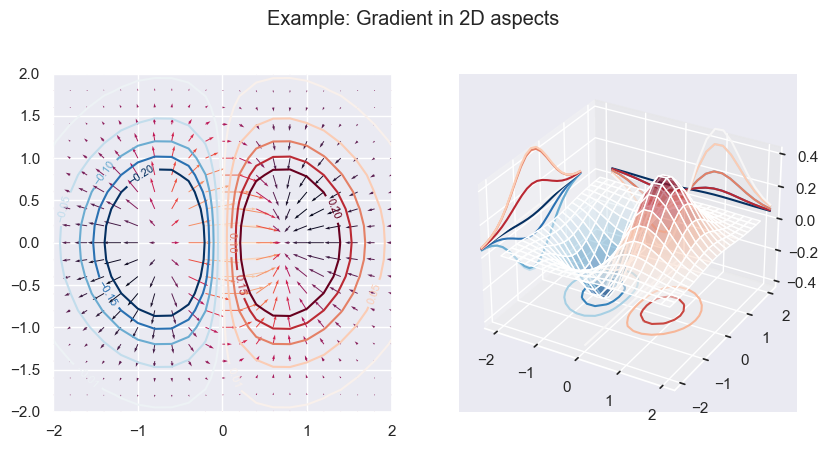

In [14]:
x = np.arange(-2,2.2,0.2)
y = np.arange(-2,2.2,0.2)


X, Y = np.meshgrid(x, y)
Z = X*np.exp(-X**2 -Y**2)
# dx, dy = np.gradient(z)
z = lambda X: X[0]*np.exp(-X[0]**2 -X[1]**2)
pts = np.vstack((X.ravel(), Y.ravel())).T         # shape: (X.size, 2)
dx, dy = num_gradient(z, pts).T                    # shape: (2, X.size)

n = -2
color_array = np.sqrt(((dx-n)/2)**2 + ((dy-n)/2)**2)

fig = plt.figure(figsize=plt.figaspect(0.5))
fig.suptitle('Example: Gradient in 2D aspects')

ax = fig.add_subplot(1, 2, 1)
cmap = cm.RdBu_r
ax.quiver(X,Y,dx,dy,color_array)
cntr = ax.contour(X, Y, Z, [-0.2, -0.15, -0.1, -0.05, -0.01, 0.01, 0.05, 0.1, 0.15, 0.2],
            linestyles='-', cmap=cmap)
plt.clabel(cntr, inline=1, fontsize=8)
ax.set_aspect('equal')


ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(X, Y, Z, cmap=cmap, alpha=0.5)
ax.contour(X, Y, Z, zdir='z', offset=-0.4, cmap=cmap)
ax.contour(X, Y, Z, zdir='x', offset=-2.5, cmap=cmap)
ax.contour(X, Y, Z, zdir='y', offset=2.5, cmap=cmap)
ax.set_aspect('auto')

plt.show()

In [15]:
# differenciation in numertical way
def num_diff(f, x): # for function of one variable x.
    h = 1e-4
    return (f(x + h) - f(x - h)) / (2*h)

def num_partial_diff(f, x, idx): # for function of an array x with index idx
    x = x.astype('float')
    h = 1e-4
    original = x[idx]
    x[idx] = original + h
    fxih1 = f(x)

    x[idx] = original - h
    fxih2 = f(x)
    
    x[idx] = original
    return (fxih1 - fxih2) / (2*h) 

A = np.arange(1, 10).reshape(3, 3)
f = lambda x: x * x + 2 * x
num_partial_diff(f, A, (0,1))

array([[0., 6., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

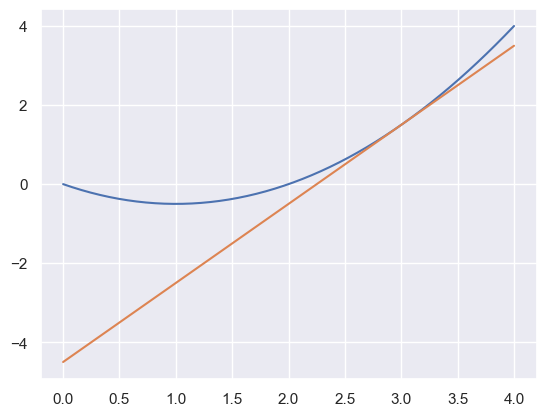

In [16]:
# tangent line
def tangent_line(f, x):
    slope = num_diff(f, x)
    return lambda t: slope*(t - x) + f(x)

f = lambda x: 0.5* x**2 - x
x = np.linspace(0, 4)
plt.plot(x, f(x))
plt.plot(x, tangent_line(f, 3)(x))
plt.show()

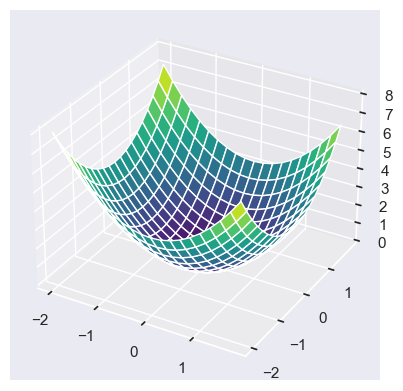

In [17]:
def function_2d(x):
    if x.ndim == 1:
        return np.sum(x**2)
    else:
        return np.sum(x**2, axis=1)

x = np.arange(-2, 2, 0.2)
y = x.copy()
X, Y = np.meshgrid(x, y)
pts = np.vstack((X.ravel(), Y.ravel())).T       # (X.size, 2) shape
z = function_2d(pts).reshape(x.size, y.size)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, z, cmap='viridis')
plt.show()

## 3. 학습의 기초: Gradient Descent, GD
extreme point극점을 찾는 것이 목표인데, Gradient Descent 방법은 최급경사방향으로 적응적 탐색이동하는 알고리즘이다.  
$$\begin{align}
\mathbf{x} &\leftarrow \mathbf{x} - \eta\frac{\partial f}{\partial \mathbf{x}}, \quad \mathbf{x} = \begin{bmatrix}
x_1 \\
\vdots \\ 
x_n
\end{bmatrix}, \quad \eta : \text{ learning rate, } \quad \frac{\partial f}{\partial \mathbf{x}} = \begin{bmatrix}
\frac{\partial f}{\partial x_1} \\
\vdots \\
\frac{\partial f}{\partial x_n}
\end{bmatrix}, \text{or} \\
\mathbf{W} &\leftarrow \mathbf{W} - \eta \frac{\partial L}{\partial \mathbf{W}}, \quad L \text{ : Loss, } \quad 
\frac{\partial L}{\partial \mathbf{W}} = \begin{bmatrix}
\frac{\partial L}{\partial w_{11}} & \cdots & \frac{\partial L}{\partial w_{1\ell}} \\
\vdots & \ddots & \vdots\\
\frac{\partial L}{\partial w_{n1}} & \cdots & \frac{\partial L}{\partial w_{n\ell}}
\end{bmatrix}\end{align}
$$

- 학습률이 적절하게 설정되어야 원하는 수준으로 적당한 steps 이내에 최적점으로 근접할 수 있다.

optimal point:  [1.00159585]


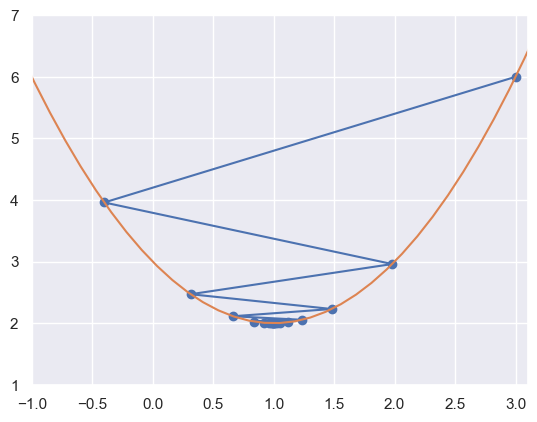

In [18]:
f = lambda x: x**2 - 2*x + 3
init_x = np.array([3.0])
eta = 0.85      # learning rate
steps = 20
x_history = []
x = init_x
for i in range(steps):
    x_history.append(x.copy())
    x -= eta*num_gradient(f, x) # update x

X = np.array(x_history)[:,0]
print("optimal point: ", x)
plt.scatter(X, f(X))
plt.plot(X, f(X))
X_ = np.linspace(-3., 3.2)
plt.plot(X_, f(X_))
plt.xlim(-1, 3.1)
plt.ylim(1, 7)
plt.show()

In [19]:
def gradient_descent(f, init_x, eta=0.05, steps=20):
    x = init_x
    x_history = []
    for i in range(steps):
        x_history.append(x.copy())
        x -= eta * num_gradient(f, x)
    return x, np.array(x_history)

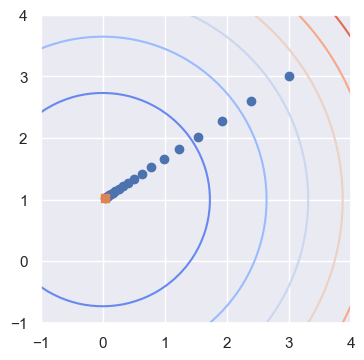

In [20]:
f = lambda x: x[0]**2 +(x[1] - 1)**2 + 1
f_ = lambda x, y: x**2 +(y - 1)**2 + 1
eta = 0.1
steps = 20
init_x = np.array([3., 3.])
x, pts =gradient_descent(f, init_x, eta,steps)

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)
ax.scatter(*pts.T)
ax.scatter(*x, marker='s')

x = np.linspace(-1, 4)
y = x.copy()
X, Y = np.meshgrid(x, y)
ax.contour(X, Y, f_(X, Y), cmap=cm.coolwarm)
plt.show()

## 4. Minimal Code Work in Learning Algorithm for labeled classification.
- 신경망 학습의 통상 절차
    1. 미니배치 선정/투입계획
    2. 손실 함수에 대해서, 각 parameter들의 gradient 를 구한다.
    3. 룰에 따라 parameter들을 갱신한다.
    4. 적정 수준으로 최적화 되기 까지 1~3을 반복한다.

- *미니 배치를 무작위 선정*하여 투입계획에 따라 Gradient Descent를 구하는 방식을 **확률적 경사 하강법,SGD**
  Stochastic Gradient Descent이라고 한다.

- 컴퓨터가 학습에 들어가기 전, 작성자에 의해 설정하게 되는 초기 파라미터는 Hyperparameter로 불리며, 학습상태에 따라 재조정한다.
- 신경망 레이어의 조정 대상인 weights 파라미터들은 normal분포로 무작위 설정하는 것이 보통이다.

In [21]:
class Network_2L:           # stub of Network with 2 layers
    def __init__(self) -> None:
        self.W = np.random.randn(2, 3)

    def predict(self, x):
        return np.dot(x, self.W)
    
    def loss(self, x, t):
        z = self.predict(x)
        y = self.softmax(z)
        return cross_entropy_error(y, t)
    
    def gradient(self, f, x):
        pass
    def gradient_descent(self, f, init_x, eta=0.05, steps=20):
        pass
    def accuracy(self):
        pass
    
    def softmax(self, z):           # max along the batch_size, axis=0
        C = np.max(z, axis=0)       # shape: (batch_size, output_feature_size)
        expo = np.exp(z - C)
        return expo/np.sum(expo)

    

net = Network_2L()
# x = np.array([0.3, 0.6])
x = np.array([[0.7, 0.9], [0.5, 0.8]])
p = net.predict(x)
print(p.shape)
# t = np.array([0, 0, 1])
t = np.array([[0, 0, 1], [0, 1, 0]])
net.loss(x, t)

(2, 3)


1.6502213987625938

In [22]:
class Network_2L:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01) -> None:
        self.params = {}
        self.params['W1'] = weight_init_std*np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std*np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']

        a1 = np.dot(x, W1) + b1
        z1 = self.sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = self.softmax(a2)

        return y

    def loss(self, x, t):                   # -->> predict
        y = self.predict(x)
        return self.cross_entropy_error(y, t)

    def accuracy(self, x, t):               # -->> predict
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)

        return np.sum(y == t)/float(x.shape[0])

    def numerical_gradient(self, x, t):     # -->> loss -->> predict
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        
        grads['W1'] = self.num_gradient(loss_W, self.params['W1'])
        grads['b1'] = self.num_gradient(loss_W, self.params['b1'])
        grads['W2'] = self.num_gradient(loss_W, self.params['W2'])
        grads['b2'] = self.num_gradient(loss_W, self.params['b2'])

        return grads

    # It takes so long to calculate gradient matrix using above numerical_gradient.
    # This is more fast by using back-propagation introduced in depth on the next time.
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = self.sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = self.softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        dz1 = np.dot(dy, W2.T)
        da1 = self.sigmoid_grad(z1) * dz1
        grads['W1'] = np.dot(x.T, da1)
        grads['b1'] = np.sum(da1, axis=0)

        return grads

    # functions
    def sigmoid(self, a):
        return 1/(1+np.exp(-a))

    def sigmoid_grad(self, x):
        return (1 - self.sigmoid(x)) * self.sigmoid(x)

    def softmax(self, x):          # x.shape: (records, features)
        if x.ndim==2:
            x_ = x.T         # to preserve records while broadcasting
            C = np.max(x_, axis=0)
            x_ = x_ - C      # to prevent overflow
            xp = np.exp(x_)  # xp.shape: (features, records)
            return (xp / np.sum(xp, axis=0)).T  # reverse the shape
        elif x.ndim ==1:
            C = np.max(x)
            xp = np.exp(x - C)
            return xp / np.sum(xp)
        else:
            print("Input is NOT of the supported types. ")
            raise 

    # CEE for both one-hot encoding and valued labels
    def cross_entropy_error(self, y, t):
        """CEE:
        Cross Entropy Error for a batch y and one-hot label t.
        The idea is that one-hot encoding has only 1 at the true element and 0 elsewhere,
        so that t * log(y) == 0. Hence, the only valid element is the 1 and to 
        obtain the result, one only has to simply calculate on that element.

        parameters
        ----------
        y, t: probability array
            If y -> 0, log(y) -> -oo. Hence, delta was introduced.
        batch_size: number of data of a batch

        returns
        -------
        float
        """
        if y.ndim == 1:
            y = y.reshape(1, y.size)
            t = t.reshape(1, t.size) 

        if y.size == t.size: # if one-hot
            t = t.argmax(axis=1) # recover label values 

        delta = 1e-7
        batch_size = y.shape[0]
        return - np.sum(np.log(y[np.arange(batch_size), t] + delta)) / batch_size

    def num_gradient_without_batch(self, f, x):
        """Gradient of a scalar valued function in a numerical way.
        x.size iteration required!
        At position x known in numerical values, for each i, we calculate
        f(xi + h) and f(xi - h), Hence, at least, 2 * x.size computations
        are needed.

        Parameters
        ----------
        f : scalar valued function of an array
        x : input array of any shape.

        Return
        ------
        gradient: An array of the shape of x
        """
        h = 1e-4     # small displacement
        grad = np.zeros_like(x)
        # iterate (the size of x) times
        it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
        while not it.finished:
            idx = it.multi_index
            original = x[idx]
            # xi -> xi + h : forward
            x[idx] = float(original) + h
            fxh1 = f(x) # f(xi + 1)
            # xi -> xi - h : backward
            x[idx] = float(original) - h
            fxh2 = f(x) # f(xi - 1)
            # average difference: central difference
            grad[idx] = (fxh1 - fxh2) / (2*h)
            x[idx] = original # retrieve the original value

            it.iternext()

        return grad

        
    def num_gradient(self, f, X):
        """Gradient of a scalar valued function in a numerical way.
        Since X may be a batch data or not, reshaping X and iteration by batch_size
        are required.

        Parameters
        ----------
        f : scalar valued function of an array
        X : input array of any shape with "first dimension of batch_size".

        Return
        ------
        gradient: An array of the shape of X
        """

        if X.ndim == 1:
            # X = X.reshape(1, X.size)
            return self.num_gradient_without_batch(f, X)    
        grad = np.zeros_like(X)

        for i, x in enumerate(X):    # for each record x in a batch X
            grad[i] = self.num_gradient_without_batch(f, x)

        return grad

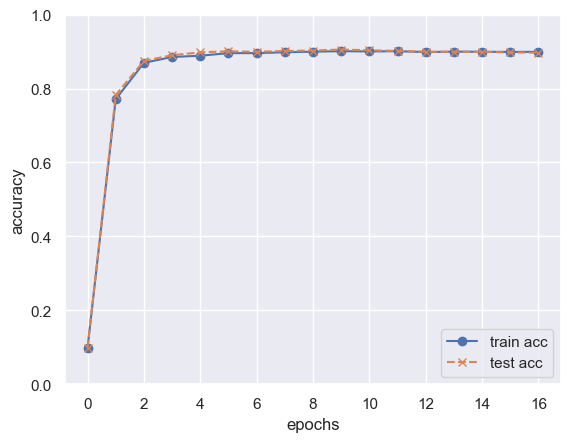

In [23]:
from dataset.mnist import load_mnist
# MNIST 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

# 2층 신경망 클래스
network = Network_2L(input_size=784, hidden_size=50, output_size=10)

# 하이퍼파라미터
iters_num = 10000 # 반복 횟수
train_size = x_train.shape[0]
batch_size = 100    # 미니배치 크기
learning_rate = 0.1   # 학습률

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    # grad = network.numerical_gradient(x_batch, t_batch) # took so long...
    grad = network.gradient(x_batch, t_batch)
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        # print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))
        
# 정확도 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train acc')
plt.plot(x, test_acc_list, marker='x', label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

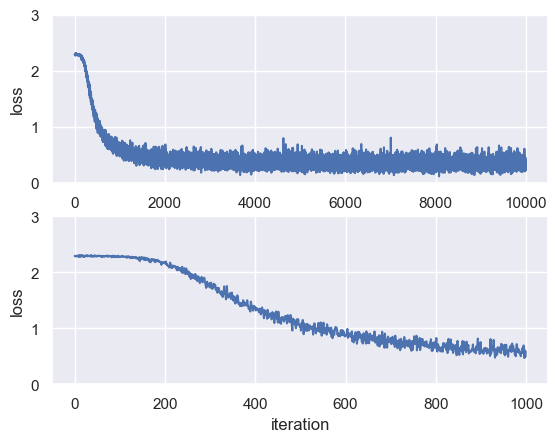

In [24]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=False)
x = np.array(range(iters_num))
ax1.plot(x, train_loss_list, label='loss')
ax1.set_xlabel('iteration')
ax1.set_ylabel('loss')
ax1.set_ylim(0, 3.0)

ax2.plot(x[:1000], train_loss_list[:1000], label='loss')
ax2.set_xlabel("iteration")
ax2.set_ylabel('loss')
ax2.set_ylim(0, 3.0)

plt.show()

<figure>
  <h1> References </h1>
  <ol style="counter-reset:item;list-style:nonce;">
     <p>
        <li style="counter-increment:item;content:'['c counter(item) ']';margin-right:30px;">사이토 고키, <cite>"밑바닥부터 시작하는 딥러닝"</cite>, (2017)</li키
     </p>
     <p>
        <li>오렐리앙 제롱,박해선, <cite>"핸즈온 머신러닝"</cite>, 2nd edition, (2022)</li>
     </p>
     <p>
        <li>호그,매킨,크레이크 <cite>"수리통계학 개론"</cite>, 7th edition, (2018)</li>
     </p>
     <p>
        <li>아즈마 유키나가,유세라, <cite>"처음 만나는 AI수학 with 파이썬"</cite>, (2021)</li>
     </p>
  </ol>
</figure>